# Goal
Train models using any methods you have learned so far to achieve best accuracy on the testing data. You can plot the train.csv and try to ensemble models that performs well on different competitors

The dataset we are going to ue is [playground](https://github.com/nthu-datalab/ml/tree/master/labs/08_CV_Ensembling/CV_playground_dataset).

This data includes four competitors and their (x, y) coordinations while they doing some exercise in the playground.

# Step
1. Your code and accuracy by all the models you have tried, which will at least include voting, bagging, and boosting models
2. Use Gridsearch to fine-tune your results. In particular, for base learner of adaboost, we hope you can try decision stump (decision tree with depth 1) and decision tree with higher depths
3. Try to evaluate and summarize the results

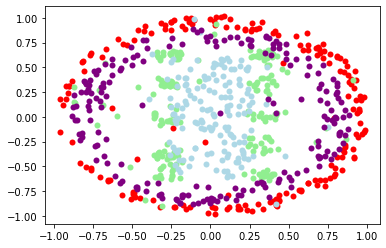

In [8]:
import numpy as np
import csv
import matplotlib.pyplot as plt

file = open('data/train.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X = np.ndarray((0, 2))
y = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
    i += 1
    X = np.vstack((X, np.array(row[0:2])))
    y = np.append(y, y_mapping[row[2]])
X = X.astype(np.float)
y = y.astype(np.float)
file.close()

plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Bob', c='red', linewidths=0)
plt.scatter(
    X[y == 1, 0], X[y == 1, 1], label='Kate', c='lightgreen', linewidths=0)
plt.scatter(
    X[y == 2, 0], X[y == 2, 1], label='Mark', c='lightblue', linewidths=0)
plt.scatter(X[y == 3, 0], X[y == 3, 1], label='Sue', c='purple', linewidths=0)


In [11]:
X

array([[ 0.41712647,  0.31674683],
       [-0.30705816, -0.89532596],
       [ 0.32364683, -0.26715998],
       ...,
       [-0.31597443,  0.94779446],
       [-0.7630671 , -0.51858159],
       [ 0.01559517, -0.83637823]])

In [29]:
X.shape

(738, 2)

## Voting

In [10]:
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', LogisticRegression(C = 10, random_state = 0, solver = "liblinear")]])
pipe2 = Pipeline([['clf', DecisionTreeClassifier(max_depth = 3, random_state = 0)]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors = 5)]])

In [18]:
import itertools
from sklearn.model_selection import cross_validate

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print('[Voting]')

best_vt, best_w, best_score = None, (), -1
for a, b, c in list(itertools.permutations(range(0,3))): # try some weight combination
    clf = VotingClassifier(estimators=[('lr', pipe1), ('dt', pipe2), ('knn', pipe3)], 
                           voting='soft', weights=[a,b,c])
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='accuracy')
    print('%s: %.3f (+/- %.3f)' % ((a,b,c), scores.mean(), scores.std()))
    if best_score < scores.mean():
        best_vt, best_w, best_score = clf, (a, b, c), scores.mean()

print('\nBest %s: %.3f' % (best_w, best_score))


[Voting]
(0, 1, 2): 0.824 (+/- 0.044)
(0, 2, 1): 0.759 (+/- 0.032)
(1, 0, 2): 0.827 (+/- 0.054)
(1, 2, 0): 0.508 (+/- 0.047)
(2, 0, 1): 0.810 (+/- 0.055)
(2, 1, 0): 0.502 (+/- 0.044)

Best (1, 0, 2): 0.827


### Result of Voting

The best ensemble combines the ```Logistic Regreesion``` and ```K-neighbors```.
(1, 0, 2)

## Bagging

In [14]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=0)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, 
                        max_samples=0.7, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=1, random_state=1)


In [17]:
from sklearn.metrics import accuracy_score

# single DecisionTree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' % (tree_train, tree_test))
# Bagging
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('[Bagging] accuracy-train = %.3f, accuracy-test = %.3f' % (bag_train, bag_test))


[DecisionTree] accuracy-train = 1.000, accuracy-test = 0.750
[Bagging] accuracy-train = 0.993, accuracy-test = 0.804


## Boosting

Let's train an ```AdaBoostClassifier``` from Scikit-learn with 500 decision trees of depth 1:

In [19]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
# single decision tree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (tree_train, tree_test))

# adaboost
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500)
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('[AdaBoost] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (ada_train, ada_test))


[DecisionTree] accuracy-train = 0.375, accuracy-test = 0.331
[AdaBoost] accuracy-train = 0.612, accuracy-test = 0.439


### Try with max_depth = 10

In [20]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=10)
# single decision tree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (tree_train, tree_test))

# adaboost
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500)
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('[AdaBoost] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (ada_train, ada_test))


[DecisionTree] accuracy-train = 0.966, accuracy-test = 0.743
[AdaBoost] accuracy-train = 1.000, accuracy-test = 0.811


In [28]:
n_estimators = [100, 300, 500, 750, 100]

tree_10 = DecisionTreeClassifier(criterion='entropy', max_depth=10)
tree_1 = DecisionTreeClassifier(criterion='entropy', max_depth=1)

param_grid = {
    'clf__n_estimators': n_estimators,
    'clf__base_estimator': [tree_10, tree_1]
}

# GirdSearch with adaboost
ada = AdaBoostClassifier()
#ada = ada.fit(X_train, y_train)

pipe_tree = Pipeline([['clf', ada]])

gs = GridSearchCV(estimator=pipe_tree, param_grid=param_grid, scoring='accuracy', cv=10)
gs.fit(X_train, y_train)

best_clf = gs.best_estimator_
best_clf.fit(X_train, y_train)

y_train_pred = best_clf.predict(X_train)
y_test_pred = best_clf.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('[GridSearch with AdaBoost] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (ada_train, ada_test))

print(gs.best_params_)

[GridSearch with AdaBoost] accuracy-train = 1.000, accuracy-test = 0.770
{'clf__base_estimator': DecisionTreeClassifier(criterion='entropy', max_depth=10), 'clf__n_estimators': 750}


The result of Grid Search is worse than only AdaboostClassifier with tree max_depth=10.
I think the reason is because the number of training data is quite small (750).
Even though we use these to do cross validation and try with different parameter, result is worse. The data bias might be small but the accuracy of test is bad due to overfitting.

So let's try with different depth from 1 to 10.

In [33]:
n_estimators = [100, 300, 500, 750, 100]

tree = DecisionTreeClassifier(criterion='entropy')

param_grid = {
    'clf__base_estimator__max_depth':[i for i in range(1,10)],
    'clf__n_estimators': n_estimators
}

# GirdSearch with adaboost
ada = AdaBoostClassifier(base_estimator=tree)
#ada = ada.fit(X_train, y_train)

pipe_tree = Pipeline([['clf', ada]])

gs = GridSearchCV(estimator=pipe_tree, param_grid=param_grid, scoring='accuracy', cv=10)
gs.fit(X_train, y_train)

best_clf = gs.best_estimator_
best_clf.fit(X_train, y_train)

y_train_pred = best_clf.predict(X_train)
y_test_pred = best_clf.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('[GridSearch with AdaBoost] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (ada_train, ada_test))

print(gs.best_params_)

[GridSearch with AdaBoost] accuracy-train = 1.000, accuracy-test = 0.811
{'clf__base_estimator__max_depth': 7, 'clf__n_estimators': 300}


After tuning the depth and estimartors, the best score of test is 0.811.
If the tree with depth is 1. Classifier can't train well, and thus have high bias and high variance. As for the tree with depth is 10. Classifier is overfitting, which means low bias and high variance.

The overall best score is voting which combine the ```Logistic regression``` and ```KNeighborsClassifier```. Score is 0.827.